In [76]:
# d for coin futures, f for usd s futures
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import requests as re
import pandas as pd
pd.set_option('display.max_rows', 1000)

COIN_API = 'https://dapi.binance.com'
USD_API = 'https://fapi.binance.com'

g_api_key='eJBYUpKfnUCA5wXDfJTKGPNaOoyLtnXIb9D6GKFbnABLCndVRRYJrdyI9rMi6D54'
g_secret_key='970sbCiGtH1W4rPW56I4MBbD9brKZegyveedljt3U3D5hry7zMbxa4sxacA80kUv'
headers = {"Accept": "application/json"}

In [15]:
epoch = datetime.utcfromtimestamp(0)
def dt_from_ms(ms):
    return datetime.utcfromtimestamp(ms / 1000.0)

def dt_to_ms(dt):
    delta = dt - epoch
    return int(delta.total_seconds() * 1000)

def get_pairs(isCoin):
    suff = '/dapi/v1/exchangeInfo' if isCoin else '/fapi/v1/exchangeInfo'
    url = COIN_API if isCoin else USD_API
    result = re.get(url+suff, headers=headers)
    symbolObjs = result.json()['symbols']
    symbols = [x['symbol'] for x in symbolObjs]
    perpetuals = list(filter(lambda x: 'PERP' in x, symbols))
    futures = list(filter(lambda x: 'PERP' not in x, symbols))
    return {'perpetuals': perpetuals, 'futures': futures}

def get_funding_rate(isCoin, pair, start_date, end_date, limit=1000):
    start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
    end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
    start_date = dt_to_ms(datetime(start_year, start_month, start_day))
    end_date = dt_to_ms(datetime(end_year, end_month, end_day))
    suff = '/dapi/v1/fundingRate' if isCoin else '/fapi/v1/fundingRate'
    suff += '?symbol='+pair+'&startTime='+str(start_date)+'&endTime='+str(end_date)+'&limit='+str(limit)
    url = COIN_API if isCoin else USD_API
    result = re.get(url+suff, headers=headers)
    data = result.json()
    funding_rate, funding_time = [], []
    for funding in data:
        funding_rate.append(float(funding['fundingRate'])*100)
        funding_time.append(dt_from_ms(funding['fundingTime']))
    df = pd.DataFrame({'Time':funding_time,'Rate':funding_rate})
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time',inplace=True)
    return df

def get_kline_data(isCoin, pair, start_date, end_date, limit=1000, interval='1h'):
    start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
    end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
    start_date = dt_to_ms(datetime(start_year, start_month, start_day))
    end_date = dt_to_ms(datetime(end_year, end_month, end_day))
    suff = '/dapi/v1/klines' if isCoin else '/fapi/v1/klines'
    suff += '?symbol='+pair+'&startTime='+str(start_date)+'&endTime='+str(end_date)+'&limit='+str(limit)+'&interval='+interval
    url = COIN_API if isCoin else USD_API
    result = re.get(url+suff, headers=headers)
    data = result.json()
    closePrice, time = [], []
    for ohlc in data:
        closePrice.append(float(ohlc[4]))
        time.append(dt_from_ms(ohlc[0]))
    df = pd.DataFrame({'Time':time,pair:closePrice})
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time',inplace=True)
    return df

In [5]:
# TODO: clean up
isCoin=True
pairs = get_pairs(isCoin)
perpetuals = pairs['perpetuals']
futures = pairs['futures']
#perpetuals = list(filter(lambda x: '210' not in x, futures))
#futures = list(filter(lambda x: '210' in x, futures))
start_date, end_date = '20210201','20210221'
df_ret = {'Pair':[],'AvgFunding':[],'FundingSharpe':[],'AvgBasis1':[],'CurrBasis1':[],'Basis1EV':[],'AvgBasis2':[],'CurrBasis2':[],'Basis2EV':[]}
for p in perpetuals:
    print(p)
    df = get_funding_rate(isCoin, p, start_date, end_date, limit=1000)
    mean_rate = df.mean()['Rate']
    sharpe = mean_rate / df.std()['Rate']
    # get futures data
    perp_data = get_kline_data(isCoin, p, start_date, end_date)
    try:
        fut1_data = get_kline_data(isCoin, p[0:p.index('_')]+'_210326', start_date, end_date)
    except:
        continue
        print(p, 'failed')
    try:
        fut2_data = get_kline_data(isCoin, p[0:p.index('_')]+'_210625', start_date, end_date)
    except:
        continue
        print(p, 'failed)')
    tot_data = perp_data.join(fut1_data).join(fut2_data)
    tot_data['diff1_pct'] = 100*(tot_data[p[0:p.index('_')]+'_210326'] - tot_data[p]) / tot_data[p]
    diff1_pct_mean = tot_data.mean()['diff1_pct']
    curr_diff1_pct = tot_data.tail(1)['diff1_pct'].values[0]
    tot_data['diff2_pct'] = 100*(tot_data[p[0:p.index('_')]+'_210625'] - tot_data[p]) / tot_data[p]
    diff2_pct_mean = tot_data.mean()['diff2_pct']
    curr_diff2_pct = tot_data.tail(1)['diff2_pct'].values[0]
    df_ret['Pair'].append(p[0:p.index('_')])
    df_ret['AvgFunding'].append(mean_rate * 3 * 365)
    df_ret['FundingSharpe'].append(sharpe)
    df_ret['AvgBasis1'].append(diff1_pct_mean)
    df_ret['CurrBasis1'].append(curr_diff1_pct)
    df_ret['Basis1EV'].append(-(curr_diff1_pct-diff1_pct_mean))
    df_ret['AvgBasis2'].append(diff2_pct_mean)
    df_ret['CurrBasis2'].append(curr_diff2_pct)
    df_ret['Basis2EV'].append(-(curr_diff2_pct-diff2_pct_mean))
df_ret = pd.DataFrame(df_ret)

BTCUSD_PERP
ETHUSD_PERP
LINKUSD_PERP
BNBUSD_PERP
TRXUSD_PERP
DOTUSD_PERP
ADAUSD_PERP
EOSUSD_PERP
LTCUSD_PERP
BCHUSD_PERP
XRPUSD_PERP
ETCUSD_PERP
FILUSD_PERP
EGLDUSD_PERP
DOGEUSD_PERP
UNIUSD_PERP
THETAUSD_PERP
XLMUSD_PERP


In [6]:
df_ret.sort_values(by=['FundingSharpe']).round(2)

,Pair,AvgFunding,FundingSharpe,AvgBasis1,CurrBasis1,Basis1EV,AvgBasis2,CurrBasis2,Basis2EV
3,BNBUSD,115.48,0.77,2.85,3.56,-0.71,5.45,8.79,-3.34
6,ADAUSD,82.03,0.80,0.32,1.37,-1.05,1.88,2.89,-1.00
2,LINKUSD,41.72,1.04,3.94,3.96,-0.02,8.23,8.17,0.06
11,ETCUSD,78.91,1.21,NaN,NaN,NaN,NaN,NaN,NaN
10,XRPUSD,92.79,1.40,0.73,1.32,-0.59,2.25,3.93,-1.68
4,TRXUSD,101.43,1.46,NaN,NaN,NaN,NaN,NaN,NaN
5,DOTUSD,123.79,1.63,4.67,4.33,0.34,9.94,10.38,-0.44
12,FILUSD,107.21,1.69,5.60,7.49,-1.89,NaN,NaN,NaN
1,ETHUSD,99.39,1.75,4.63,3.71,0.92,8.94,9.31,-0.36
0,BTCUSD,86.42,1.87,4.44,3.63,0.81,8.77,9.21,-0.44


<AxesSubplot:title={'center':'ETHUSD_PERP Funding Rate (Annualized)'}, xlabel='Time'>

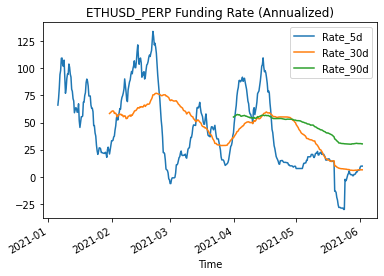

In [36]:
perpetual = 'ETHUSD_PERP'
start_date = '20210101'
end_date = '202106029'
rates_df = get_funding_rate(isCoin, perpetual, start_date, end_date, limit=1000)
for d in [5,30,90]:
    rates_df['Rate_'+str(d)+'d'] = rates_df['Rate'].rolling(d*3).mean() * 3*365
rates_df.plot(y=['Rate_5d','Rate_30d','Rate_90d'],title=perpetual+" Funding Rate (Annualized)")

In [78]:
pairs = get_pairs(True)
perpetuals = pairs['futures']
windows = [5,30,90]
data_df = {'Pair':[],'Current':[]}
for window in windows:
    data_df[str(window)+'d'] = []
    data_df[str(window)+'d_pctNeg'] = []
for perpetual in perpetuals:
    print(perpetual)
    rates_df = get_funding_rate(True, perpetual, start_date, end_date, limit=1000)
    if not rates_df.empty:
        data_df['Pair'].append(perpetual)
        data_df['Current'].append(rates_df['Rate'].tail(1).values[0]*3*365)
        for d in windows:
            data_df[str(d)+'d'].append((rates_df['Rate'].rolling(d*3).mean() * 3*365).tail(1).values[0])
            data_df[str(d)+'d_pctNeg'].append((rates_df['Rate'].tail(d*3) < 0).sum() / (rates_df['Rate'].tail(d*3)).count()*100)
data_df = pd.DataFrame(data_df).round(1)
data_df.sort_values('30d')

BTCUSD_210924
BTCUSD_211231
ETHUSD_210924
ETHUSD_211231
ADAUSD_210924
LINKUSD_210924
BCHUSD_210924
DOTUSD_210924
XRPUSD_210924
LTCUSD_210924
BNBUSD_210924
ADAUSD_211231
LINKUSD_211231
BCHUSD_211231
DOTUSD_211231
XRPUSD_211231
LTCUSD_211231
BNBUSD_211231


,Pair,Current,5d,5d_pctNeg,30d,30d_pctNeg,90d,90d_pctNeg


In [77]:
data_df.sort_values('30d')

,Pair,Current,5d,5d_pctNeg,30d,30d_pctNeg,90d,90d_pctNeg
84,ANKRUSDT,-28.3,-75.7,86.7,-45.1,64.4,31.6,30.7
46,RUNEUSDT,-12.2,-36.9,93.3,-33.6,47.8,23.4,25.2
74,AXSUSDT,1.2,-26.6,40.0,-30.2,55.6,42.0,25.6
18,IOTAUSDT,-47.0,-59.3,100.0,-25.6,47.8,64.7,16.3
79,1INCHUSDT,-24.3,-72.8,80.0,-24.4,40.0,48.4,14.8
7,ETCUSDT,-42.1,-55.9,100.0,-20.5,50.0,28.9,17.4
58,HNTUSDT,-10.3,-182.8,86.7,-19.0,17.8,47.9,8.5
42,BALUSDT,-94.5,-42.9,73.3,-18.8,40.0,38.9,18.1
48,SRMUSDT,11.0,-33.8,80.0,-17.4,40.0,54.0,15.6
43,CRVUSDT,-30.6,-23.8,86.7,-14.6,42.2,41.2,18.5
